Импорт библиотек 

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import io
import re

In [4]:
df = pd.read_csv('commercial_props.txt', sep = ',')
df.head()

,request_id,date,sector,client_request,commercial_proposal,budget_est,status
0,R-1001,2023-09-01,Web Dev,I need a WordPress landing page for my flower ...,Turnkey WP site + hosting setup + 1h training.,$800,Accepted
1,R-1002,2023-09-02,Design,Need a minimalist logo for a tech startup call...,"3 logo concepts, vector files, and favicon inc...",$450,Pending
2,R-1003,2023-09-02,Translation,Translate a 5-page legal contract from English...,Certified translation by a native jurist. 48h ...,$0.15/word,Accepted
3,R-1004,2023-09-03,Content,Write 4 SEO-optimized articles about 'Solar En...,Content Pack: Keyword research + 4 articles + ...,$600,Negotiating
4,R-1005,2023-09-04,Data,Scrape email addresses from 500 LinkedIn profi...,Lead generation service: formatted CSV deliver...,$250,Rejected


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   request_id           100 non-null    object
 1   date                 100 non-null    object
 2   sector               100 non-null    object
 3   client_request       100 non-null    object
 4   commercial_proposal  100 non-null    object
 5   budget_est           100 non-null    object
 6   status               100 non-null    object
dtypes: object(7)
memory usage: 5.6+ KB


In [8]:
df.isnull().sum()

request_id             0
date                   0
sector                 0
client_request         0
commercial_proposal    0
budget_est             0
status                 0
dtype: int64

In [10]:
# ---------------------------------------------------------
# 2. ПРЕДОБРАБОТКА ДАННЫХ (Data Cleaning)
# ---------------------------------------------------------
# Колонка 'budget_est' содержит '$' и иногда текст (e.g. '/word', '/week').
# Нам нужно вытащить чистое число для анализа.

def clean_budget(value):
    # Если значение < 1, это вероятно цена за слово, умножим условно на объем (для графиков)
    # но лучше просто пометить такие данные как "Variable"
    if pd.isna(value):
        return 0
    # Удаляем $ и берем первое числовое значение (float)
    match = re.search(r"(\d+(\.\d+)?)", str(value))
    if match:
        return float(match.group(1))
    return 0

In [11]:
# Создаем числовую колонку для анализа
df['budget_numeric'] = df['budget_est'].apply(clean_budget)
# Флаг для тех сделок, где бюджет за единицу (word/week)
df['is_variable_rate'] = df['budget_est'].astype(str).str.contains('/word|/week', na=False)
df.head()

,request_id,date,sector,client_request,commercial_proposal,budget_est,status,budget_numeric,is_variable_rate
0,R-1001,2023-09-01,Web Dev,I need a WordPress landing page for my flower ...,Turnkey WP site + hosting setup + 1h training.,$800,Accepted,800.00,False
1,R-1002,2023-09-02,Design,Need a minimalist logo for a tech startup call...,"3 logo concepts, vector files, and favicon inc...",$450,Pending,450.00,False
2,R-1003,2023-09-02,Translation,Translate a 5-page legal contract from English...,Certified translation by a native jurist. 48h ...,$0.15/word,Accepted,0.15,True
3,R-1004,2023-09-03,Content,Write 4 SEO-optimized articles about 'Solar En...,Content Pack: Keyword research + 4 articles + ...,$600,Negotiating,600.00,False
4,R-1005,2023-09-04,Data,Scrape email addresses from 500 LinkedIn profi...,Lead generation service: formatted CSV deliver...,$250,Rejected,250.00,False


In [14]:
# Оцениваем пропуски
missing_values = df.isnull().sum()
print("\n=== Пропущенные значения ===")
print(missing_values[missing_values > 0])


=== Пропущенные значения ===
Series([], dtype: int64)


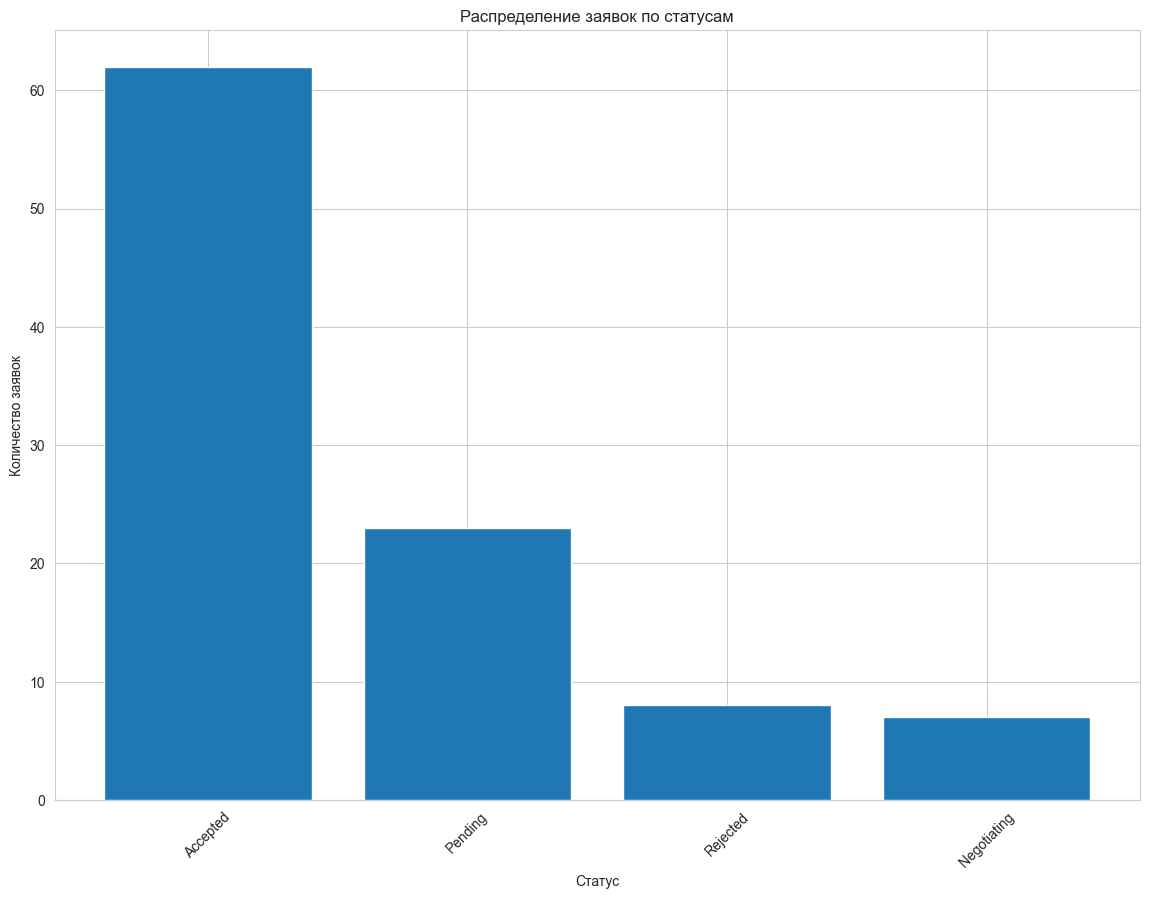

In [ ]:
status_counts = df['status'].value_counts()

plt.figure()
plt.bar(status_counts.index, status_counts.values)
plt.title("Распределение заявок по статусам")
plt.xlabel("Статус")
plt.ylabel("Количество заявок")
plt.xticks(rotation=45)
plt.show()


<Figure size 1400x1000 with 0 Axes>

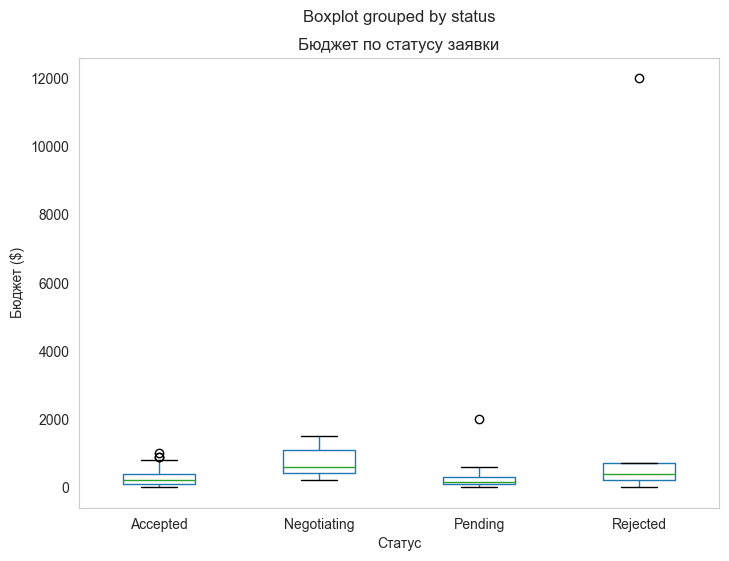

In [42]:
plt.figure()
boxplot = df.boxplot(column ='budget_numeric', by='status', grid=False, figsize=(8,6))
plt.title("Бюджет по статусу заявки")
plt.xlabel("Статус")
plt.ylabel("Бюджет ($)")

plt.show()

In [38]:
# 4. ВЫВОДЫ (Analysis & Report)
# ---------------------------------------------------------

avg_budget = df['budget_numeric'].mean()
acceptance_rate = len(df[df['status'] == 'Accepted']) / len(df) * 100
sector_stats = df.groupby('sector')['budget_numeric'].mean().sort_values(ascending=False).head(3)

print("\n====== ОТЧЕТ ПО АНАЛИЗУ ДАННЫХ ======")
print(f"1. Объем выборки: {len(df)} записей.")
print(f"2. Конверсия (Acceptance Rate): {acceptance_rate:.1f}% заявок принимаются.")
print(f"3. Средний чек (Fixed Price): ${avg_budget:.2f}.")
print(f"4. Самые дорогие ниши (средний чек):")
print(sector_stats)
print("\nГипотеза для ML: Статус заявки слабо зависит от суммы, но может зависеть от сложности описания задачи в тексте.")


====== ОТЧЕТ ПО АНАЛИЗУ ДАННЫХ ======
1. Объем выборки: 100 записей.
2. Конверсия (Acceptance Rate): 62.0% заявок принимаются.
3. Средний чек (Fixed Price): $448.40.
4. Самые дорогие ниши (средний чек):
sector
Dev Mobile    12000.000000
Security       2000.000000
Data            511.111111
Name: budget_numeric, dtype: float64

Гипотеза для ML: Статус заявки слабо зависит от суммы, но может зависеть от сложности описания задачи в тексте.
